# EAF Coffea-Casa Benchmark Example 3 - Gateway and HTCondor

In [1]:
import numpy as np
%matplotlib inline
from coffea import hist
import coffea.processor as processor
import awkward as ak
from coffea.nanoevents import schemas

In [2]:
# This program plots a per-event array (jet_pt) that has been masked to meet certain conditions 
#(in this case, abs(jet eta) < 1).

class Processor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "")
        Jet_axis = hist.Bin("Jet_pt", "Jet_pt [GeV]", 100, 15, 60)
        
        self._accumulator = processor.dict_accumulator({
            'Jet_pt': hist.Hist("Counts", dataset_axis, Jet_axis),
            'cutflow': processor.defaultdict_accumulator(int)
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, events):
        output = self.accumulator.identity()
        
        dataset = events.metadata['dataset']
        
        # NanoEvents allows easy access to our jets with the Jet column.
        jets = events.Jet

        output['cutflow']['all events'] += ak.size(jets, axis=0)
        output['cutflow']['number of jets'] += ak.sum(ak.num(jets))
        
        # We want jets with an abs(eta) < 1. Conditionals act on every value in an array in Coffea, so this is easy.
        eta_max = (np.absolute(jets.eta) < 1)
        # eta_max is a Boolean array, with True in the place of values where the condition is met, and False otherwise.
        #We want to sum up all the Trues (=1) in each sublist, 
        #then sum up all the sublists to get the number of jets with pt > 20.
        output['cutflow']['abs(eta) < 1'] += ak.sum(ak.sum(eta_max, axis=1))
            
        # We define good_jets as the actual jets we want to graph. We mask it with the jets that have abs(eta) < 1.
        good_jets = jets[eta_max]
        # good_jets is no longer a Boolean array, so we can't just sum up the True's. 
        #We count the amount of jets and sum that.
        output['cutflow']['final good jets'] += ak.sum(ak.num(good_jets, axis=1))
        
        output['Jet_pt'].fill(dataset=dataset, Jet_pt=ak.flatten(good_jets.pt))
        return output

    def postprocess(self, accumulator):
        return accumulator

# Connecting to the gateway
The code in the following cell imports the LPCGateway and connects to a cluster of HTCondor workers.
* gateway.new_cluster() starts a new cluster
* cluster.scale(N) specifies the number of workers in the cluster, here there are N workes in the cluster
* cluster.get_client() obtains the client that will connect your cluster to the scheduler, this is how the HTCondor workers are assigned to your tasks on the grid

In [3]:
from lpcdaskgateway import LPCGateway

gateway = LPCGateway()
cluster = gateway.new_cluster()
cluster

# Scale my cluster to 5 HTCondor workers
cluster.scale(5)

# Obtain a client for connecting to your cluster scheduler
# Your cluster should be ready to take requests
client = cluster.get_client()
client

INFO:lpcdaskgateway.LPCGateway: Creating LPCGatewayCluster 
INFO:lpcdaskgateway.GatewayCluster: Scaling: 5 HTCondor workers
INFO:lpcdaskgateway.GatewayCluster: Sandbox: /uscmst1b_scratch/lpc1/3DayLifetime/elisec/dask-gateway.e81b92d4b75842cf892e35aaaa2b04ee
INFO:lpcdaskgateway.GatewayCluster: Success! submitted HTCondor jobs to lpcschedd2.fnal.gov with  ClusterId 37113554


Client Scheduler: gateway://172.30.227.32:80/dask-gateway.e81b92d4b75842cf892e35aaaa2b04ee Dashboard: https://dask-gateway.fnal.gov/clusters/dask-gateway.e81b92d4b75842cf892e35aaaa2b04ee/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Warning: running on HTCondor could take some time
The scheduler has to have available workers to connect to your cluster, this is what takes some time. After they connect, it should be much faster.

In [4]:
fileset = {'SingleMu' : ["root://eospublic.cern.ch//eos/root-eos/benchmark/Run2012B_SingleMu.root"]}

executor = processor.DaskExecutor(client=client)

run = processor.Runner(executor=executor,
                        schema=schemas.NanoAODSchema,
                        savemetrics=True
                      )

output, metrics = run(fileset, "Events", processor_instance=Processor())

metrics

INFO:numexpr.utils:Note: NumExpr detected 22 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
[                                        ] | 0% Completed |  0.1s

/opt/conda/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/conda/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/conda/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


{'bytesread': 2727541868,
 'columns': ['nJet', 'Jet_pt', 'Jet_eta'],
 'entries': 53446198,
 'processtime': 367.077064037323,
 'chunks': 534}

<AxesSubplot:xlabel='Jet_pt [GeV]', ylabel='Counts'>

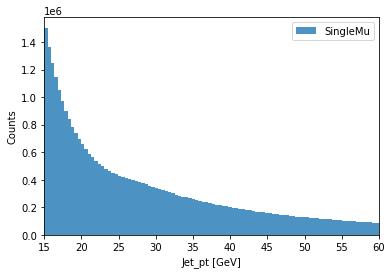

In [5]:
hist.plot1d(output['Jet_pt'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})

In [6]:
for key, value in output['cutflow'].items():
    print(key, value)

all events 53446198
number of jets 170952895
abs(eta) < 1 39563735
final good jets 39563735


### Do not forget to shutdown your cluster
cluster.shutdown() does that gracefully

In [7]:
cluster.shutdown()

INFO:lpcdaskgateway.GatewayCluster: Shutting down HTCondor worker jobs
INFO:lpcdaskgateway.GatewayCluster: All jobs in cluster 37113554 have been marked for removal
